<a href="https://colab.research.google.com/github/syon1203/pytorch_project/blob/master/vision_intern_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet34_Weights
import torch.optim as optim
from google.colab import files

!pip install -q kaggle

file_upload = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Prevent Permission Warning
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d swaroopkml/cifar10-pngs-in-folders

 96% 135M/140M [00:01<00:00, 126MB/s]
100% 140M/140M [00:01<00:00, 108MB/s]


In [6]:
!ls

cifar10-pngs-in-folders.zip  kaggle.json  sample_data


In [ ]:
!unzip cifar10-pngs-in-folders.zip

In [8]:
import matplotlib.image as img

train_root = '/content/cifar10/cifar10/train'
test_root = '/content/cifar10/cifar10/test'


def get_labels(root):
    label = [f for f in os.listdir(root) if not f.startswith('.')]
    labels = {string: i for i, string in enumerate(label)}
    return labels


def match_image(root):
    images = []
    labels = {}

    for i, label in enumerate(os.listdir(root)):
        labels[i] = label
        try:
            for i in os.listdir(os.path.join(root, label)):
                image = img.imread(os.path.join(root, label,i))
                images.append((label, image))
        except:
            pass

    print("finished")
    return images

class CIFAR10(Dataset):

    def __init__(self, root, train=True, transform=None):
        super().__init__()
        self.root = root
        self.labels = get_labels(root)
        self.images = match_image(root)
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image = self.images[index][1]
        label = self.images[index][0]
        #image = Image.fromarray(np.uint8(img))

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label}

        return image, label

    def __len__(self):
        return len(self.images)

In [9]:
batch_size = 8 # minibatch size
epochs = 10 # 전체 데이터를 활용한 학습 진행 횟수
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transf_train = tr.Compose([tr.RandomCrop(32, padding=4), tr.ToTensor(),tr.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
transf_test = tr.Compose([tr.ToTensor(),tr.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


# CIFAR10 custom dataset
trainset = CIFAR10(root='/content/cifar10/cifar10/train',transform=transf_test)
testset = CIFAR10(root='/content/cifar10/cifar10/test',transform=transf_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print('number of training data: ', len(trainset))
print('number of test data: ', len(testset))

finished
finished
number of training data:  50000
number of test data:  10000


('bird', 'dog', 'automobile', 'cat', 'truck', 'deer', 'dog', 'truck')
('cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat')


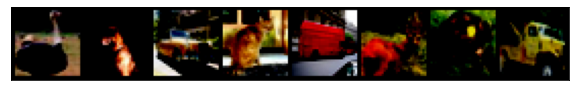

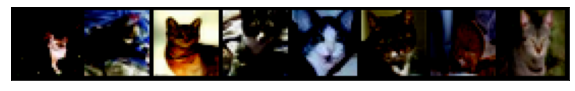

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        print(labels)
        break

show_batch(trainloader)
show_batch(testloader)

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)

cuda


In [12]:
resnet = models.resnet34(weights=ResNet34_Weights.DEFAULT)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10) # output 크기 10
resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=1e-3)

In [ ]:
best_acc = 0.0

for epoch in range(epochs):
    # Training
    resnet.train()
    train_accuracy = 0.0
    train_loss = 0.0
    # For each batch in trainloader
    for i,(images, labels) in enumerate(trainloader):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()    # Making the gradients 0 at the start of a new batch

      outputs = resnet(images)
      loss = criterion(outputs, labels)
      loss.backward()     # Backpropagation
      scheduler.step(loss)    # Update the weight and bias
        
      train_loss += loss.cpu().data*images.size(0)    # loss.cpu().data = loss
      _, prediction = torch.max(outputs.data, 1)
        
      train_accuracy += int(torch.sum(prediction==labels.data))
        
    train_loss = train_loss/len(trainset)
    train_accuracy = train_accuracy/len(trainset)

    #evaluation 전환
    resnet.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    
    for i,(images, labels) in enumerate(testloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.cpu().data*images.size(0)    # loss.cpu().data = loss
        _, prediction = torch.max(outputs.data, 1)
        
        test_accuracy += int(torch.sum(prediction==labels.data))
        
    test_loss = test_loss/len(testset)
    test_accuracy = test_accuracy/len(testset)
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Loss: '+str(test_loss)+' Test Accuracy: '+str(100*test_accuracy) +'%')